In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Poisson's Equation for Electrostatics
$$\left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right) \varphi(x,y) = -\frac{\rho_e}{\epsilon_r \epsilon_0}$$
Poisson's equation for electrostatics in 2 dimensions is given above. Here we know the charge distribution $\rho_e$ and we are tasked with finding $\varphi(x,y)$. To do this we will set up a "stencil" with variable grid size and spacing. We will distribute charge density across the stencil arbitrarily, in this case using the sum of two Gaussians.

## Set up stencil

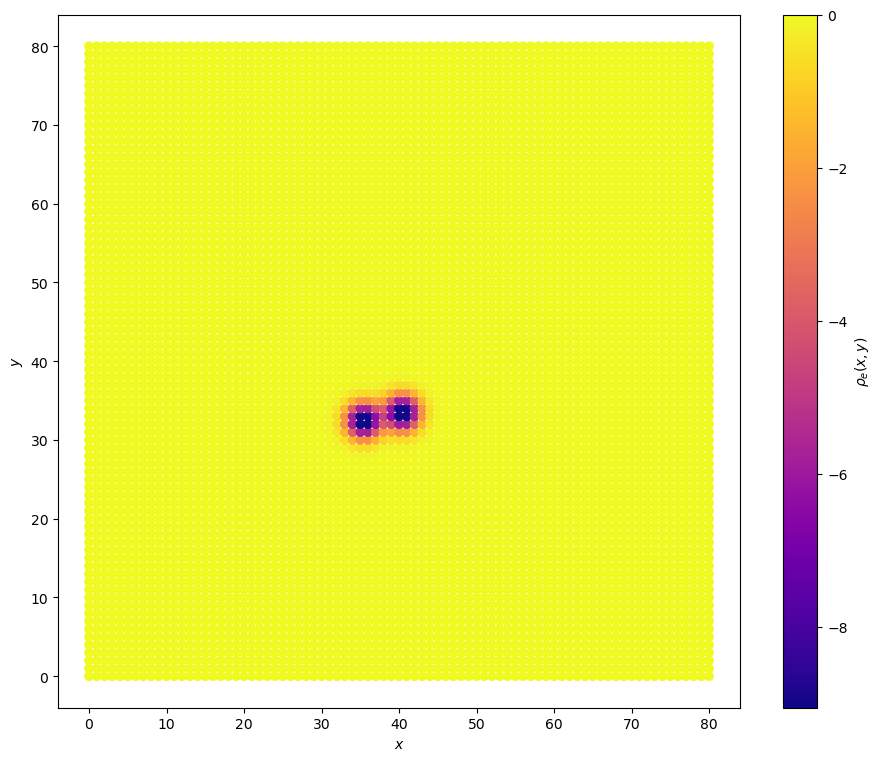

In [20]:
stencil_dimensions = ((0,80), (0,80))
grid_spacing = 1

fig = plt.figure(figsize=(11,9))
xvals = np.arange(stencil_dimensions[0][0], stencil_dimensions[0][1]+grid_spacing, grid_spacing)
yvals = np.arange(stencil_dimensions[1][0], stencil_dimensions[1][1]+grid_spacing, grid_spacing)
for xval in xvals:
    plt.vlines(xval, ymin=min(stencil_dimensions[1]), ymax=max(stencil_dimensions[1]), color='black')
for yval in yvals:
    plt.hlines(yval, xmin=min(stencil_dimensions[0]), xmax=max(stencil_dimensions[0]), color='black')

# This arbitrary charge distribution could come from a molecule, but here it is simply two Gaussians
def arbitrary_charge_distribution(x,y):

    sigma_x = 1.5
    sigma_y = 1.5
    
    gauss1 = 10*np.exp((-(x-35.5)**2)/(2*sigma_x**2)-((y-32.5)**2)/(2*sigma_y**2))
    gauss2 = 10*np.exp((-(x-40.5)**2)/(2*sigma_x**2)-((y-33.5)**2)/(2*sigma_y**2))
    return 0 - gauss1 - gauss2

gridpoints = []
for x in xvals:
    for y in yvals:
        gridpoints.append([x, y, arbitrary_charge_distribution(x,y)])

minimum = min([gridpoint[2] for gridpoint in gridpoints])
maximum = max([gridpoint[2] for gridpoint in gridpoints])

# Each gridpoint now has form [x, y, value]

plt.scatter([gridpoint[0] for gridpoint in gridpoints], [gridpoint[1] for gridpoint in gridpoints], c=[gridpoint[2] for gridpoint in gridpoints], cmap="plasma", zorder=10)
cbar = plt.colorbar()
cbar.set_label(r"$\rho_e(x,y)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
fig.show()

## Make the matrix

Following chapter 19 of _Numerical Recipes in C_ (ISBN 0-521-43108-5), the value of $\varphi(x,y)$ relates to other gridpoints from:
$$\varphi(x+\Delta,y)+\varphi(x-\Delta,y)+\varphi(x,y+\Delta)+\varphi(x,y-\Delta)-4\varphi(x,y)=-\Delta^2\frac{\rho_e(x,y)}{\epsilon_r \epsilon_0}$$
where $\Delta$ is the grid spacing and $\rho_e(x,y)$ is the charge density at point $(x,y)$. For a derivation, see below. We need to create the matrix that represents this equation.

## (Derivation)

This equation can be derived from the following finite-difference approximations:
$$\left.\frac{\partial}{\partial x}\varphi(x,y)\right|_{\pm\Delta}\approx\frac{\varphi(x\pm\Delta,y)-\varphi(x,y)}{\pm\Delta}$$
$$\frac{\partial^2}{\partial x^2}\varphi(x,y)\approx\frac{\left.\frac{\partial}{\partial x}\varphi(x,y)\right|_{+\Delta}-\left.\frac{\partial}{\partial x}\varphi(x,y)\right|_{-\Delta}}{\Delta}\approx\frac{\frac{\varphi(x+\Delta,y)-\varphi(x,y)}{\Delta}+\frac{\varphi(x-\Delta,y)-\varphi(x,y)}{\Delta}}{\Delta}=\frac{\varphi(x+\Delta,y)}{\Delta^2}+\frac{\varphi(x-\Delta,y)}{\Delta^2}-2\frac{\varphi(x,y)}{\Delta^2}$$
$$\frac{\partial^2}{\partial y^2}\varphi(x,y)\approx\frac{\varphi(x,y+\Delta)}{\Delta^2}+\frac{\varphi(x,y-\Delta)}{\Delta^2}-2\frac{\varphi(x,y)}{\Delta^2}$$
$$\left(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}\right)\varphi(x,y)=\frac{\varphi(x+\Delta,y)}{\Delta^2}+\frac{\varphi(x-\Delta,y)}{\Delta^2}+\frac{\varphi(x,y+\Delta)}{\Delta^2}+\frac{\varphi(x,y-\Delta)}{\Delta^2}-4\frac{\varphi(x,y)}{\Delta^2}=-\frac{\rho_e(x,y)}{\epsilon_r \epsilon_0}$$

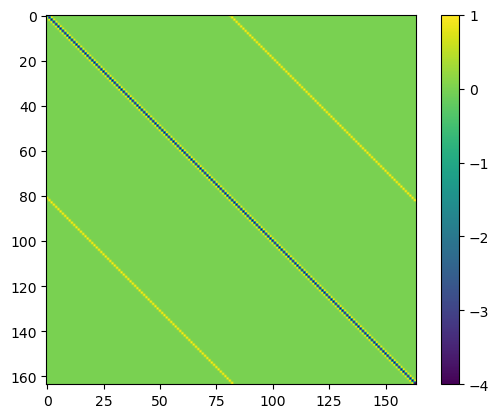

In [21]:
# Create the matrix

J = len(xvals)
L = len(yvals)

A = np.zeros((J*L,J*L))

def seteq(A, i, j, val):
    try:
        A[i,j] = val
    except:
        pass
    return A

for j in range(0,J*L):
    
    A = seteq(A, j, j, -4)
    A = seteq(A, j, j+1, 1)
    if j-1 >= 0:
        A = seteq(A, j, j-1, 1)
    A = seteq(A, j, j+L, 1)
    if j-(L) >= 0:
        A = seteq(A, j, j-L, 1)

# Show the matrix
plt.imshow(A[0:2*(L+1),0:2*(L+1)])
#plt.imshow(A)
plt.colorbar()
plt.show()

## Introduce boundary values (TO BE COMPLETED)
Here we introduce boundary values $\left(\frac{\partial}{\partial x}+\frac{\partial}{\partial y}\right)\varphi(x_{b},y_{b})=0$ where $(x_b,y_b)$ is a point on the boundary. This assumes our stencil is sufficiently big.

In [9]:
# TO BE COMPLETED
pass

## Solve!
Now we have the matrix equation $\mathbf{A}\boldsymbol{\varphi}=\boldsymbol{\rho}_e$. We can solve this by letting NumPy do all of the heavy number crunching. If you have too many gridpoints this calculation can take a very long time.

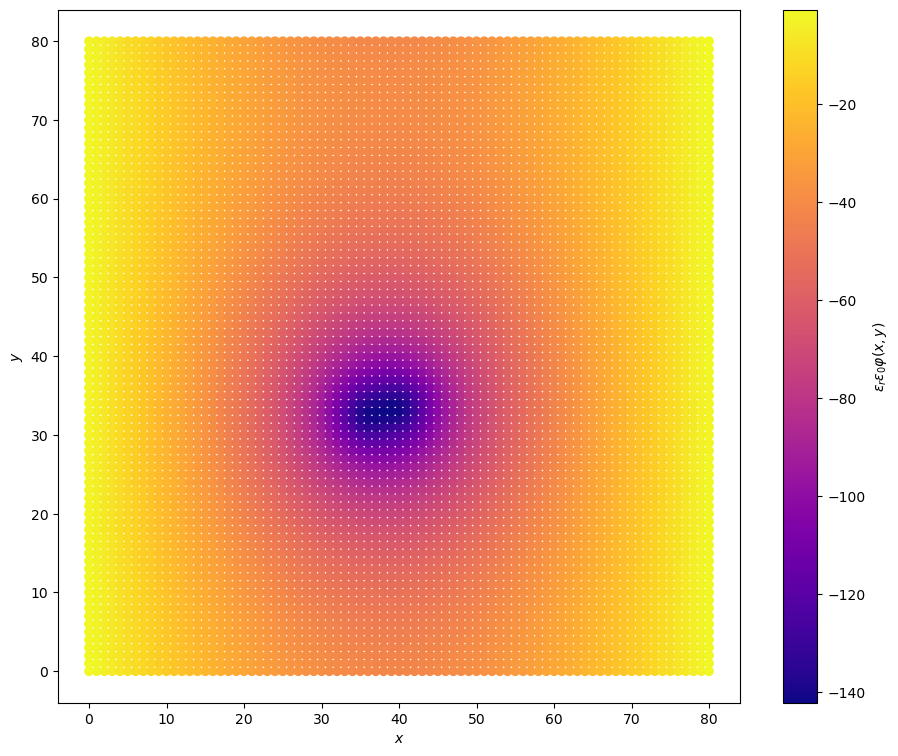

In [22]:
# We use np.linalg.solve to solve the matrix equation
rho = [gridpoint[2] for gridpoint in gridpoints]
phi = -np.linalg.solve(A,rho)

# Plot phi
fig = plt.figure(figsize=(11,9))
xvals = np.arange(stencil_dimensions[0][0], stencil_dimensions[0][1]+grid_spacing, grid_spacing)
yvals = np.arange(stencil_dimensions[1][0], stencil_dimensions[1][1]+grid_spacing, grid_spacing)
for xval in xvals:
    plt.vlines(xval, ymin=min(stencil_dimensions[1]), ymax=max(stencil_dimensions[1]), color='black')
for yval in yvals:
    plt.hlines(yval, xmin=min(stencil_dimensions[0]), xmax=max(stencil_dimensions[0]), color='black')

#phi = np.reshape(phi, (J, L))
plt.scatter([gridpoint[0] for gridpoint in gridpoints], [gridpoint[1] for gridpoint in gridpoints], c=phi, cmap="plasma", zorder=10)

# minimum = min(phi)
# for i in range(0, len(gridpoints)):
#     if phi[i] == minimum:
#         plt.scatter(gridpoints[i][0], gridpoints[i][1], color='green', marker='*', zorder=15)
        
cbar = plt.colorbar()
cbar.set_label(r"$\epsilon_r\epsilon_0\varphi(x,y)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
fig.show()

# Reshape phi so that it is a 2D matrix, going from phi(i) where i is a gridpoint to phi(x,y)
#phi = np.reshape(phi, (J, L))

# Optionally print phi(x,y)
print_phi = False
if print_phi:
    print(phi)

# Why is it not zero evenly along the boundary, just along min(x) and max(x)? Likely because I didn't set any boundary conditions :)